In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [4]:
# !unzip Potato___Early_blight.zip


In [5]:
# !unzip Potato___healthy.zip


In [6]:
# !unzip Potato___Late_blight.zip

In [7]:
# !unzip PlantVillage.zip

In [8]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [9]:
datasets=tf.keras.preprocessing.image_dataset_from_directory(
    'PlantVillage',
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE

)


Found 2152 files belonging to 3 classes.


In [10]:

# !rm -r Potato___healthy
# !rm -r Potato___Late_blight

In [11]:
class_names=datasets.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [12]:
len(datasets) # it is showing 32 since image size is of batch 32 so 68*32=2176

68

In [13]:
for image_batch,label_batch in datasets.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 0 2 1 2 0 0 0 1 0 2 1 0 2 0 0 1 1 0 2 1 0 1 0 1 2 0 0 0 2 1]


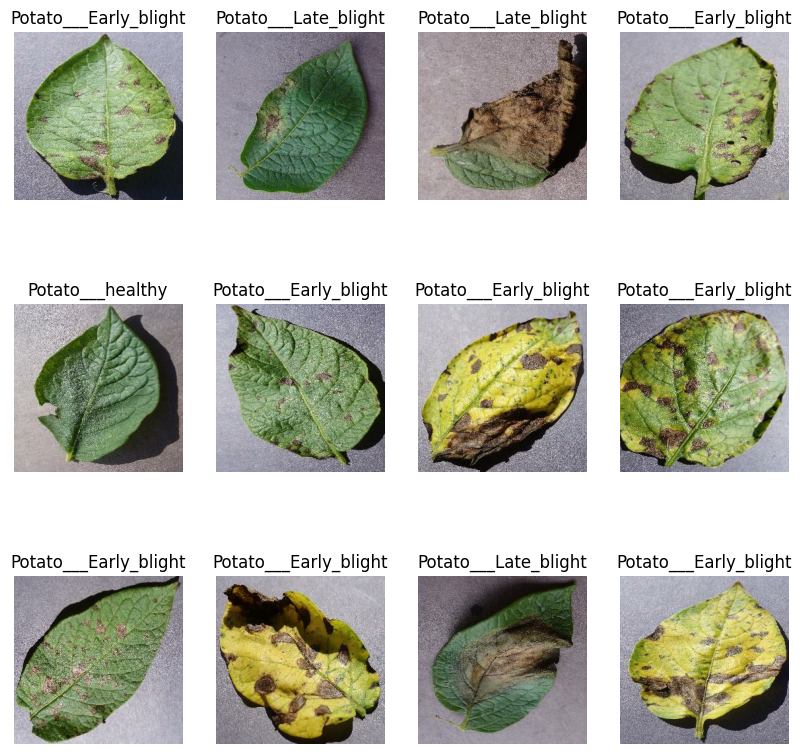

In [14]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in datasets.take(1):
  # print(image_batch[0].shape)

  for i in range(12):
    ax=plt.subplot(3,4,i+1) # here third value is indexing
    plt.imshow(image_batch[i].numpy().astype("int"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")
plt.show()

In [15]:
len(datasets)

68

In [16]:
train_size=0.8
len(datasets)*train_size

54.400000000000006

In [17]:
train_ds=datasets.take(54)
len(train_ds)

54

In [18]:
temp_ds=datasets.skip(54)
len(temp_ds)

14

In [19]:
val_size=0.1
len(datasets)*val_size

6.800000000000001

In [20]:
val_ds=temp_ds.take(6)
len(val_ds)

6

In [21]:
test_ds=temp_ds.skip(6)
len(test_ds)

8

In [22]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
  ds_size=len(ds)
  train_size=int(train_split*ds_size)
  val_size=int(val_split*ds_size)
  if shuffle:
    ds=ds.shuffle(shuffle_size,seed=12)
  train_ds=ds.take(train_size)
  val_ds=ds.skip(train_size).take(val_size)
  test_ds=ds.skip(train_size).skip(val_size)
  return train_ds,val_ds,test_ds

In [23]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(datasets)

In [24]:
len(train_ds)

54

In [25]:
len(val_ds)

6

In [26]:
len(test_ds)

8

prefetch:when gpu is runing  the train datasets the cpu will load the next batch
cache:
On the frist epoch we read the file or images but in the second epoch we don't have the read the image which saves a lot tine

In [27]:
train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [28]:
resize_and_rescale=tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE,IMAGE_SIZE), # if test image ar enot of same dimension it will handle that
    tf.keras.layers.Rescaling(1.0/255)
])

In [29]:
data_augmentation=tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2)
])

In [30]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
#CNN MODEL
model=keras.Sequential([
    resize_and_rescale,
    data_augmentation,
    tf.keras.layers.Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=input_shape),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(len(class_names),activation='softmax')

])
model.build(input_shape=input_shape)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [31]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [33]:
history=model.fit(train_ds,epochs=EPOCHS,batch_size=BATCH_SIZE,verbose=1,validation_data=val_ds)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - accuracy: 0.4941 - loss: 0.9166 - val_accuracy: 0.7135 - val_loss: 0.5921
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.6925 - loss: 0.6238 - val_accuracy: 0.8988 - val_loss: 0.3680
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.8393 - loss: 0.3823 - val_accuracy: 0.8594 - val_loss: 0.3303
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.8858 - loss: 0.2838 - val_accuracy: 0.8906 - val_loss: 0.2867
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.8986 - loss: 0.2397 - val_accuracy: 0.8958 - val_loss: 0.1889
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.8986 - loss: 0.2480 - val_accuracy: 0.6198 - val_loss: 0.6619
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.9091 - loss: 0.2465 - val_accuracy: 0.8958 - val_loss: 0.2782
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.9621 - loss: 0.1098 - val_accuracy: 0.9375 

In [34]:
scores=model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9817 - loss: 0.0698


In [35]:
scores

[0.07743319123983383, 0.98046875]

In [36]:
history

In [37]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [38]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [40]:
history.history['accuracy']

[0.5260416865348816,
 0.7546948194503784,
 0.8350939154624939,
 0.8990610241889954,
 0.8867371082305908,
 0.875,
 0.9254694581031799,
 0.9600939154624939,
 0.966549277305603,
 0.966549277305603,
 0.954812228679657,
 0.9659624695777893,
 0.9776995182037354,
 0.9835680723190308,
 0.9841549396514893,
 0.9724178314208984,
 0.9853286147117615,
 0.98591548204422,
 0.9823943376541138,
 0.9890046119689941,
 0.9890046119689941,
 0.9814814925193787,
 0.9882628917694092,
 0.9771126508712769,
 0.9733796119689941,
 0.984375,
 0.9788732528686523,
 0.9837962985038757,
 0.9722222089767456,
 0.9797453880310059,
 0.9895833134651184,
 0.98591548204422,
 0.9876760840415955,
 0.9924768805503845,
 0.9917840361595154,
 0.9847418069839478,
 0.9812206625938416,
 0.9771126508712769,
 0.98591548204422,
 0.9958920478820801,
 0.9865023493766785,
 0.9929577708244324,
 0.9930555820465088,
 0.9768518805503845,
 0.9929577708244324,
 0.9890046119689941,
 0.9958920478820801,
 0.9917840361595154,
 0.9600939154624939,
 0.

In [41]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

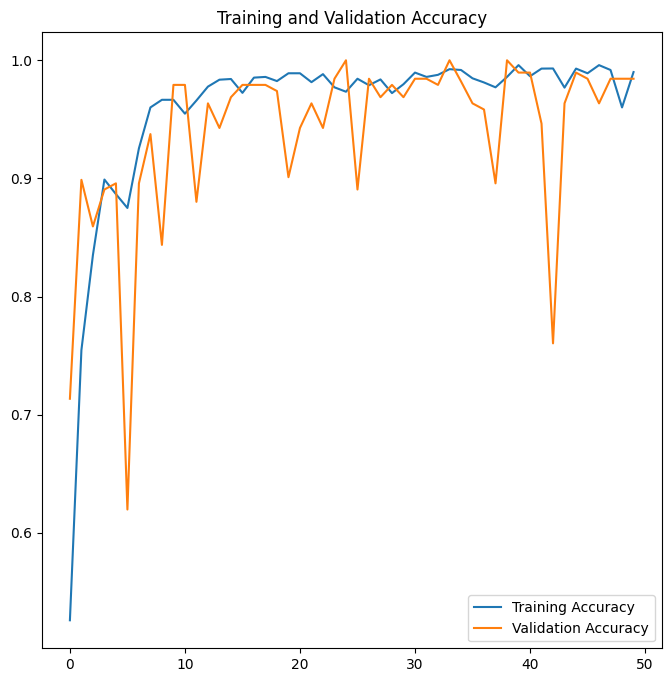

In [45]:
plt.figure(figsize=(8,8))
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


Text(0.5, 1.0, 'Training and Validation loss')

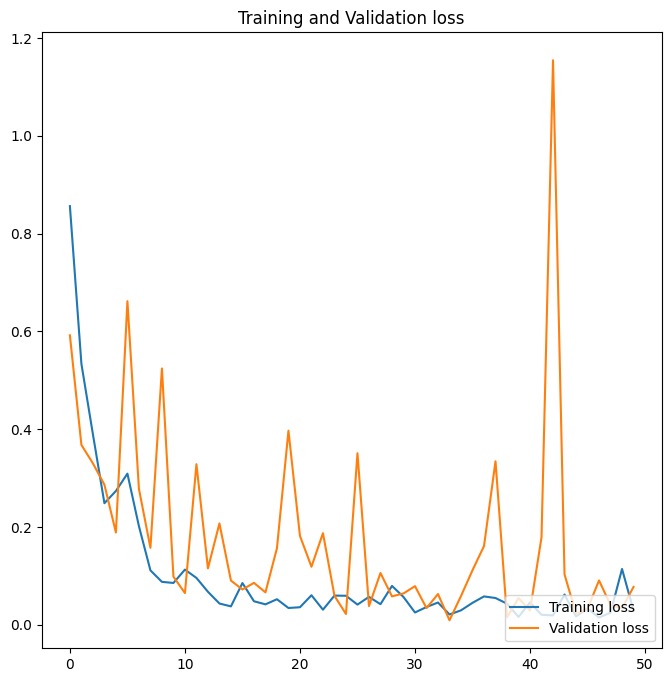

In [46]:
plt.figure(figsize=(8,8))
plt.plot(range(EPOCHS),loss,label='Training loss')
plt.plot(range(EPOCHS),val_loss,label='Validation loss')
plt.legend(loc='lower right')
plt.title('Training and Validation loss')

First image to predict 
Frist image's actual label:  Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Prediction:  Potato___Early_blight


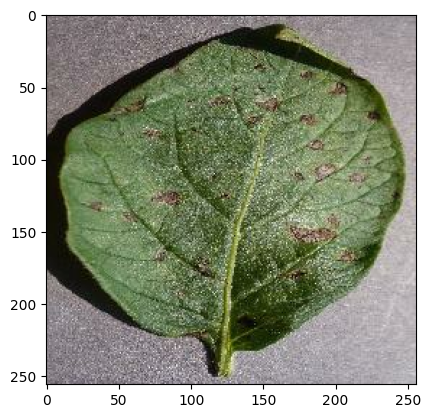

In [68]:
for image_batch,label_batch in test_ds.take(1):
  first_image=(image_batch[0].numpy().astype("int"))
  first_label=label_batch[0].numpy()
  print("First image to predict ")
  plt.imshow(first_image)
  print("Frist image's actual label: ",class_names[first_label])

  batch_prediction=model.predict(image_batch)
  print("Prediction: ",class_names[np.argmax(batch_prediction[0])])

In [69]:
def predict(model,img):
  img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array=tf.expand_dims(img_array,0)
  predictions=model.predict(img_array)
  predicted_class=class_names[np.argmax(predictions[0])]
  confidence=round(100*(np.max(predictions[0])),2)
  return predicted_class,confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


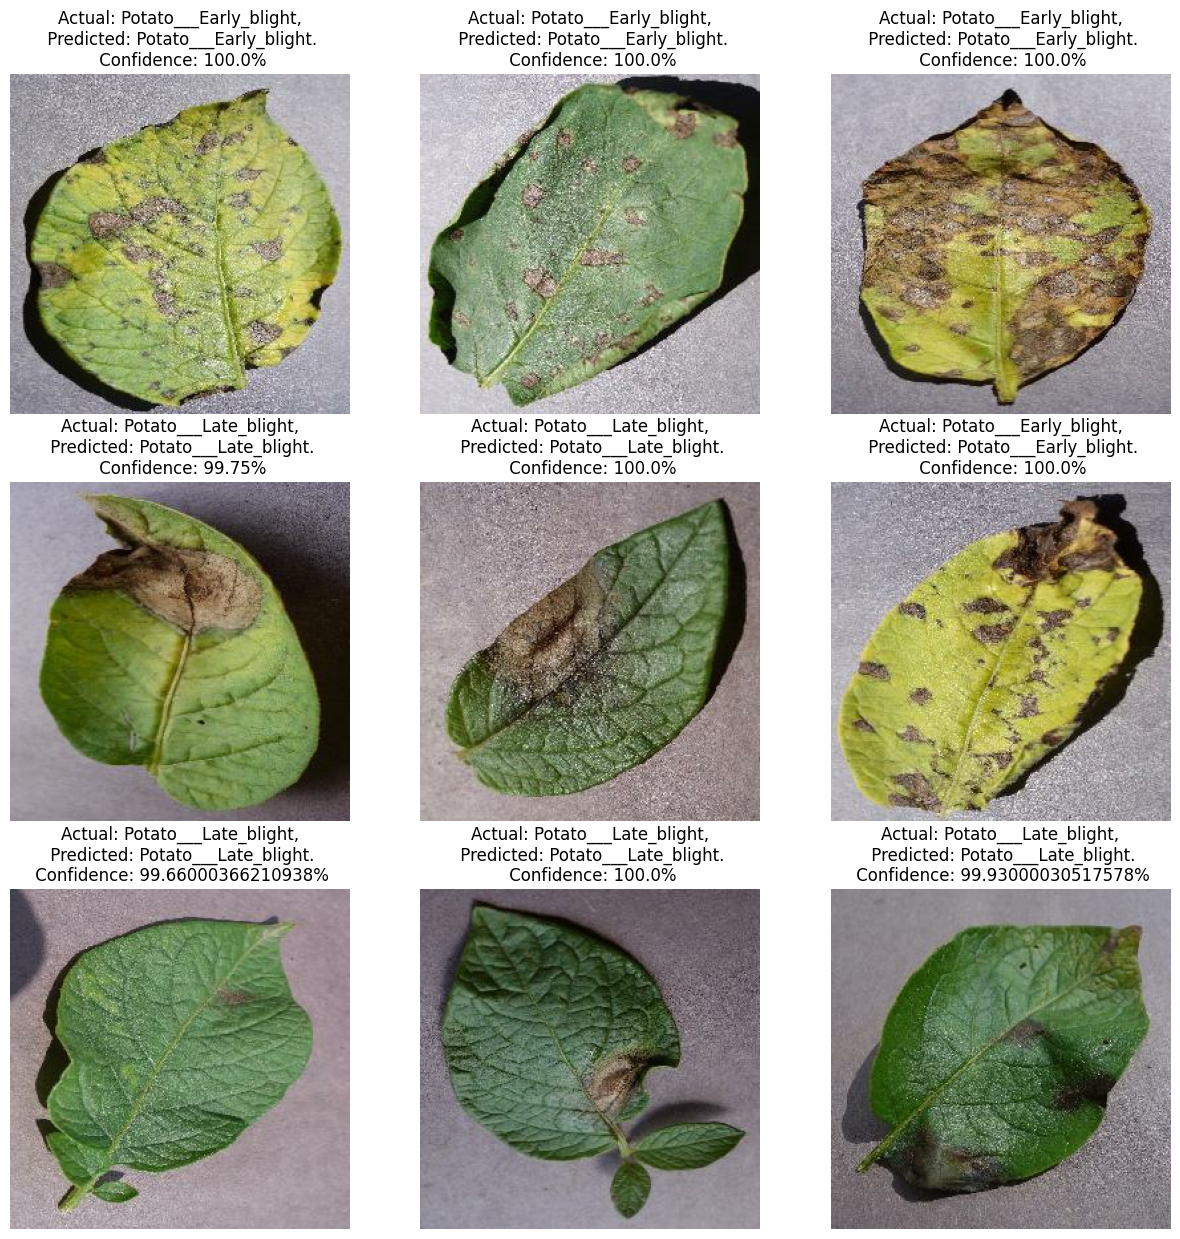

In [74]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("int"))
    predicted_class,confidence=predict(model,images[i].numpy())
    actual_class=class_names[labels[i]]
    plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
    plt.axis("off")

In [79]:
import os
os.makedirs('./models', exist_ok=True)

In [80]:
model_version=1
model.save(f"./models/{model_version}.keras")